In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

In [2]:
from collections import OrderedDict
import icon_registration.networks as networks


import torch.nn.functional as F
from icon_registration.mermaidlite import compute_warped_image_multiNC, identity_map_multiN
import torch
import random
import icon_registration.inverseConsistentNet as inverseConsistentNet
import icon_registration.network_wrappers as network_wrappers
import icon_registration.data as data
import numpy as np
import matplotlib.pyplot as plt
import itk

/playpen-raid1/tgreer/ICON/src/icon_registration/inverseConsistentNet.py:3: UserWarning: inverseConsistentNet.py is deprecated, its code has been moved to losses.py
        In a future release this file may be deleted.
  warnings.warn(


In [3]:
r_ds = torch.load("/playpen/tgreer/knees_test_set_hires")
#batched_ds = list(zip(*[r_ds[i::4] for i in range(2)]))


In [4]:
batched_ds = list(zip(*[r_ds[i::2] for i in range(2)]))

In [5]:
import random
import torch

import footsteps

import icon_registration as icon
import icon_registration.networks as networks


SCALE = 2  # 1 IS QUARTER RES, 2 IS HALF RES, 4 IS FULL RES
input_shape = [1, 1, 40 * SCALE, 96 * SCALE, 96 * SCALE]

import torch.nn
class TwoStepDownsampleRegistration(icon.RegistrationModule):
    """Combine two RegistrationModules.

    First netPhi is called on the input images at half resolution, then image_A is warped with
    the resulting field with upsampling, and then netPsi is called on warped A and image_B
    in order to find a residual warping. Finally, the composition of the two
    transforms is returned.
    """

    def __init__(self, netPhi, netPsi, dimension):
        super().__init__()
        self.netPhi = netPhi
        self.netPsi = netPsi
        if dimension == 2:
            self.avg_pool = F.avg_pool2d
            self.interpolate_mode = "bilinear"
        else:
            self.avg_pool = F.avg_pool3d
            self.interpolate_mode = "trilinear"
        self.dimension = dimension

    def forward(self, image_A, image_B):
        # Tag for optimization. Must be set at the beginning of forward because it is not preserved by .to(config.device)
        self.identity_map.isIdentity = True
        s_image_A = self.avg_pool(image_A, 2, ceil_mode=True)
        s_image_B = self.avg_pool(image_B, 2, ceil_mode=True)
        phi = self.netPhi(s_image_A, s_image_B)
        phi_vectorfield = phi(self.identity_map[:, :, ::2, ::2])
        phi_vectorfield = torch.nn.Upsample(self.identity_map.size()[2:], mode=self.interpolate_mode)(phi_vectorfield)
        self.image_A_comp_phi = self.as_function(image_A)(phi_vectorfield)
        psi = self.netPsi(self.image_A_comp_phi, image_B)

        ret = lambda input_: phi(psi(input_))
        return ret


    def assign_identity_map(self, input_shape, parents_identity_map=None):
        self.input_shape = np.array(input_shape)
        self.input_shape[0] = 1
        self.spacing = 1.0 / (self.input_shape[2::] - 1)

        _id = identity_map_multiN(self.input_shape, self.spacing)
        self.register_buffer("identity_map", torch.from_numpy(_id))

        first_child_shape = np.concatenate(
            [
                self.input_shape[:2],
                np.ceil(self.input_shape[2:] / 2).astype(int),
            ]
        )
        second_child_shape = self.input_shape
        self.netPhi.assign_identity_map(first_child_shape)
        self.netPsi.assign_identity_map(second_child_shape)



def make_network():
    inner_net = icon.FunctionFromVectorField(networks.tallUNet2(dimension=3))

    for _ in range(2):
         inner_net = TwoStepDownsampleRegistration(
             inner_net,
             icon.FunctionFromVectorField(networks.tallUNet2(dimension=3)),
             dimension=3
         )

    net = icon.GradientICON(inner_net, icon.ssd_only_interpolated, lmbda=.2)
    net.assign_identity_map(input_shape)
    return net

net = make_network()

#trained_weights = torch.load("/playpen-raid1/tgreer/ICON/training_scripts/gradICON/results/end2endlmbda.2/network_weights_29400")
trained_weights = torch.load("/playpen-raid1/tgreer/ICON/training_scripts/gradICON/results/q-16/network_weights_166500")


print(net.regis_net.load_state_dict(trained_weights))

#net.regis_net = icon.DownsampleRegistration(net.regis_net.netPhi, dimension=3)
0

<All keys matched successfully>


0

In [6]:
!ntop

Thu Sep 22 12:11:24 2022
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.80.02    Driver Version: 450.80.02    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  On   | 00000000:3B:00.0 Off |                  N/A |
| 31%   27C    P8    21W / 250W |   7636MiB / 11019MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  On   | 00000000:5E:00.0 Off |                  N/A |
| 31%   25C    

In [7]:

BATCH_SIZE = 2
SCALE = 2  # 1 IS QUARTER RES, 2 IS HALF RES, 4 IS FULL RES
input_shape = [BATCH_SIZE, 1, 40 * SCALE, 96 * SCALE, 96 * SCALE]

net.assign_identity_map(input_shape)

In [8]:

net.cuda()


GradientICON(
  (regis_net): TwoStepDownsampleRegistration(
    (netPhi): TwoStepDownsampleRegistration(
      (netPhi): FunctionFromVectorField(
        (net): UNet2(
          (downConvs): ModuleList(
            (0): Conv3d(2, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
            (1): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
            (2): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
            (3): Conv3d(64, 256, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
            (4): Conv3d(256, 512, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
          )
          (upConvs): ModuleList(
            (0): ConvTranspose3d(48, 16, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
            (1): ConvTranspose3d(96, 32, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
            (2): ConvTranspose3d(192, 64, kernel_size=(4, 4, 4), stride=(2, 2, 2), paddi

In [9]:
import icon_registration

In [10]:
net.eval()
net.cuda()
0

0

In [11]:
def flips(phi):
    a = phi[:, :, 1:, 1:, 1:] - phi[:, :, :-1, 1:, 1:]
    b = phi[:, :, 1:, 1:, 1:] - phi[:, :, 1:, :-1, 1:]
    c = phi[:, :, 1:, 1:, 1:] - phi[:, :, 1:, 1:, :-1]

    dV = torch.sum(torch.cross(a, b, 1) * c, axis=1, keepdims=True)
    return torch.sum(dV < 0)# / BATCH_SIZE
def flips2(phi):
    a = phi[:, :, 1:, 1:, 1:] - phi[:, :, :-1, 1:, 1:]
    b = phi[:, :, 1:, 1:, 1:] - phi[:, :, 1:, :-1, 1:]
    c = phi[:, :, 1:, 1:, 1:] - phi[:, :, 1:, 1:, :-1]

    dV = torch.sum(torch.cross(a, b, 1) * c, axis=1, keepdims=True) / np.product(net.spacing)
    return dV.detach().cpu()
with torch.no_grad():
    dices = []
    folds_list = []
    
    filteredDV_list = []
    
    mag = []
    
    
    for x in batched_ds[:]:
        x = list(zip(*x))
        x = [torch.cat(r, 0).cuda().float() for r in x]
        fixed_image, fixed_cartilage = x[1], x[3]
        moving_image, moving_cartilage = x[0], x[2]

        l = icon_registration.losses.to_floats(net(moving_image, fixed_image))
        mag.append(l.transform_magnitude)
        phi_AB_vectorfield = net.phi_AB(net.identity_map)
        fat_phi = torch.nn.Upsample(size=moving_cartilage.size()[2:], mode="trilinear")(phi_AB_vectorfield[:, :3])
        sz = np.array(fat_phi.size())
        spacing = 1./(sz[2::]-1) 
        warped_moving_cartilage = compute_warped_image_multiNC(moving_cartilage.float(), fat_phi, spacing, 0)
        
        #fixed_cartilage = torch.nn.
        wmb = torch.round(warped_moving_cartilage) == 1
        fb = torch.round(fixed_cartilage) == 1
        intersection = wmb * fb
        d = 2 * torch.sum(intersection, [1,2,3,4]).float() / (torch.sum(wmb, [1,2,3,4]) + torch.sum(fb, [1,2,3,4]))
        print(d)
        dices.append(d)
        f = flips(phi_AB_vectorfield[:1])
        print(f)
        folds_list.append(f.item())
        f = flips(phi_AB_vectorfield[1:])
        print(f)
        folds_list.append(f.item())
        
        dV = flips2(phi_AB_vectorfield)
        
        dV = np.array(dV).flatten()
        dV = dV[dV < 0]
        filteredDV_list.append(dV)
        
    dd = torch.mean(torch.cat(dices).cpu())
    print(dd)
    ff = np.mean(folds_list)
    print(ff)
    
    print("mag", sum(mag) / len(mag))

tensor([0.6740, 0.7397], device='cuda:0')
tensor(1069, device='cuda:0')
tensor(671, device='cuda:0')
tensor([0.7371, 0.6369], device='cuda:0')
tensor(557, device='cuda:0')
tensor(509, device='cuda:0')
tensor([0.6649, 0.6643], device='cuda:0')
tensor(487, device='cuda:0')
tensor(906, device='cuda:0')
tensor([0.7384, 0.6811], device='cuda:0')
tensor(429, device='cuda:0')
tensor(485, device='cuda:0')
tensor([0.6783, 0.7491], device='cuda:0')
tensor(605, device='cuda:0')
tensor(395, device='cuda:0')
tensor([0.7234, 0.7519], device='cuda:0')
tensor(648, device='cuda:0')
tensor(779, device='cuda:0')
tensor([0.7303, 0.5733], device='cuda:0')
tensor(374, device='cuda:0')
tensor(1138, device='cuda:0')
tensor([0.6086, 0.7514], device='cuda:0')
tensor(514, device='cuda:0')
tensor(787, device='cuda:0')
tensor([0.6884, 0.7376], device='cuda:0')
tensor(1151, device='cuda:0')
tensor(875, device='cuda:0')
tensor([0.6483, 0.6942], device='cuda:0')
tensor(576, device='cuda:0')
tensor(1294, device='cuda:

tensor([0.7027, 0.7124], device='cuda:0')
tensor(640, device='cuda:0')
tensor(387, device='cuda:0')
tensor([0.6288, 0.6112], device='cuda:0')
tensor(428, device='cuda:0')
tensor(1224, device='cuda:0')
tensor([0.7254, 0.7200], device='cuda:0')
tensor(1127, device='cuda:0')
tensor(572, device='cuda:0')
tensor([0.7079, 0.7153], device='cuda:0')
tensor(1077, device='cuda:0')
tensor(522, device='cuda:0')
tensor([0.7084, 0.7641], device='cuda:0')
tensor(422, device='cuda:0')
tensor(331, device='cuda:0')
tensor([0.6693, 0.6951], device='cuda:0')
tensor(1008, device='cuda:0')
tensor(1240, device='cuda:0')
tensor([0.7184, 0.7317], device='cuda:0')
tensor(274, device='cuda:0')
tensor(660, device='cuda:0')
tensor([0.7311, 0.7323], device='cuda:0')
tensor(1106, device='cuda:0')
tensor(762, device='cuda:0')
tensor([0.7111, 0.7231], device='cuda:0')
tensor(677, device='cuda:0')
tensor(740, device='cuda:0')
tensor([0.6748, 0.6858], device='cuda:0')
tensor(1284, device='cuda:0')
tensor(424, device='cu

0.6952965
777.1966666666667


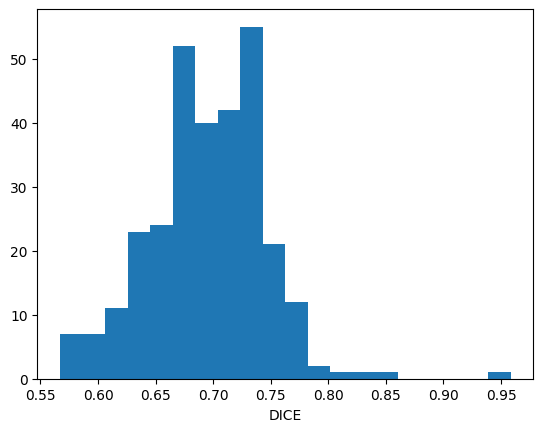

In [12]:
dicesa = np.array(torch.cat(dices).cpu())
plt.hist(dicesa, 20)
plt.xlabel("DICE")
print(np.mean(dicesa))
ff = np.mean(folds_list)
print(ff)

In [13]:
net.cuda()
with torch.no_grad():
    print(net(moving_image, fixed_image))

ICONLoss(all_loss=tensor(0.0238, device='cuda:0'), inverse_consistency_loss=tensor(0.0316, device='cuda:0'), similarity_loss=tensor(0.0175, device='cuda:0'), transform_magnitude=tensor(0.0038, device='cuda:0'), flips=tensor(853.5000, device='cuda:0'))


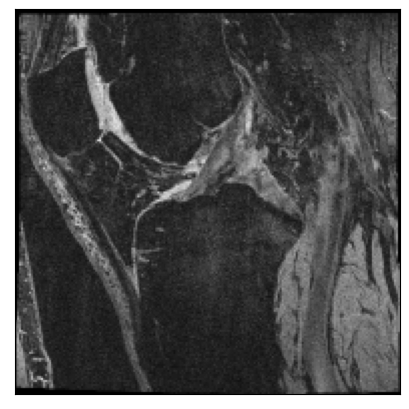

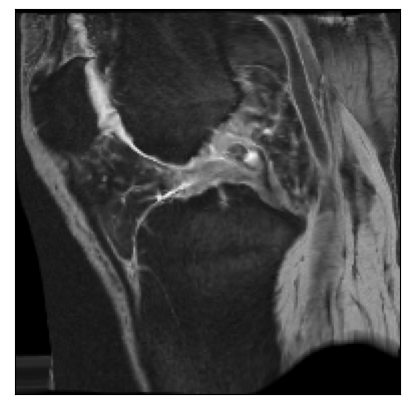

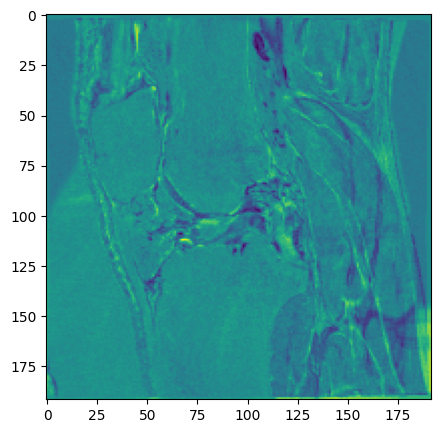

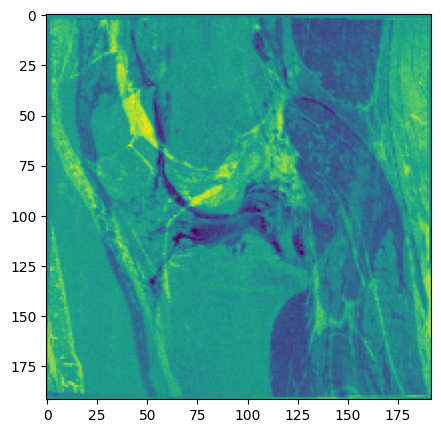

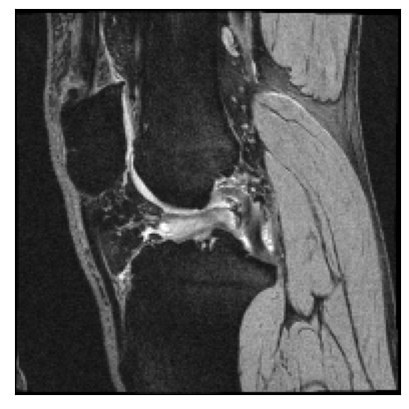

In [14]:



if not("N" in locals()):
    N = 0
N += 1
N %= 2

#N = 3
#plt.imshow(fixed_image[N, 0, 10].cpu() - net.warped_image_A[N, 0, 10].cpu().detach())
#plt.show()
plt.rcParams["figure.figsize"] = (5, 5)
def imshow(x):
    plt.xticks([])
    plt.yticks([])
    plt.imshow(np.abs(x.cpu().detach()), vmin=0, vmax=1, cmap="gray")
slice_ = 40
imshow(fixed_image[N, 0, slice_])
plt.show()
imshow(net.warped_image_A[N, 0, slice_])
plt.show()

plt.imshow(net.warped_image_B[N, 0, slice_ ].cpu().detach() - moving_image[N, 0, slice_ ].cpu().detach())
plt.show()
#plt.imshow(net.regis_net.x_comp_phi[N, 0, slice_].cpu().detach() - moving_image[N, 0, slice_].cpu().detach())
#plt.show()
plt.imshow((fixed_image - moving_image)[N, 0, slice_].cpu().detach())
plt.show()

imshow(moving_image[N, 0, slice_].cpu().detach())
plt.show()

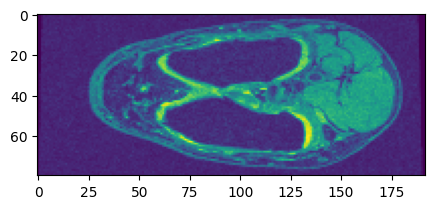

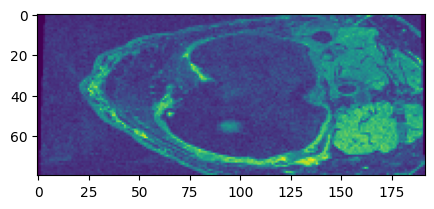

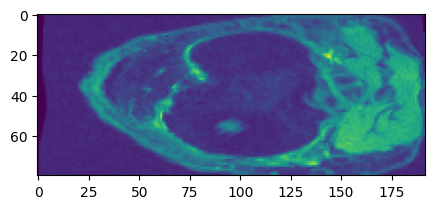

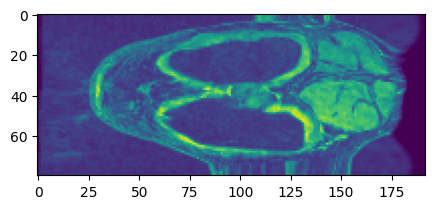

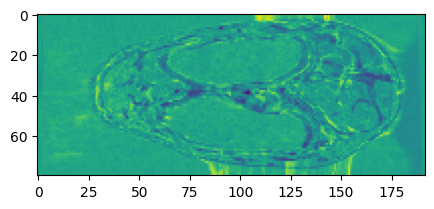

In [15]:
import matplotlib.pyplot as plt
S = 100
plt.imshow(moving_image[N, 0, :, S].cpu())
plt.show()
plt.imshow(fixed_image[N, 0, :, S].cpu())
plt.show()
plt.imshow(net.warped_image_A[N, 0, :, S].cpu().detach())
plt.show()
plt.imshow(net.warped_image_B[N, 0, :, S].cpu().detach())
plt.show()

plt.imshow(net.warped_image_B[N, 0, :, S].cpu().detach() - moving_image[N, 0, :, S].cpu())

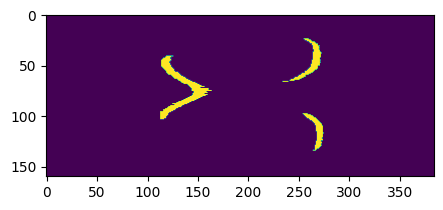

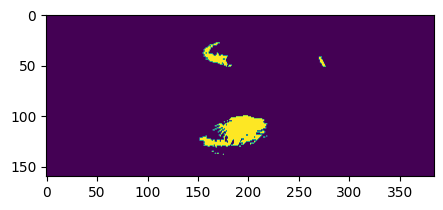

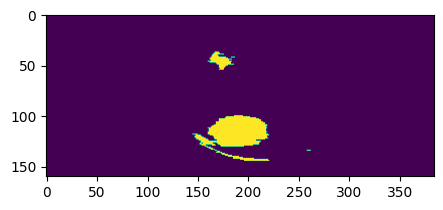

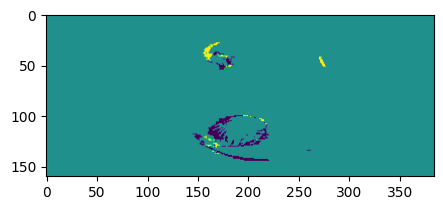

In [16]:

S = 49
plt.imshow(moving_cartilage[N, 0, :, S * 4].cpu())
plt.show() 
plt.imshow(warped_moving_cartilage[N, 0, :, S * 4].detach().cpu())
plt.show()

plt.imshow(fixed_cartilage[N, 0, :, S * 4].cpu())
plt.show()

plt.imshow((warped_moving_cartilage[N, 0, :, S * 4].detach().cpu() - fixed_cartilage[N, 0, :, S * 4].cpu()))
plt.show()


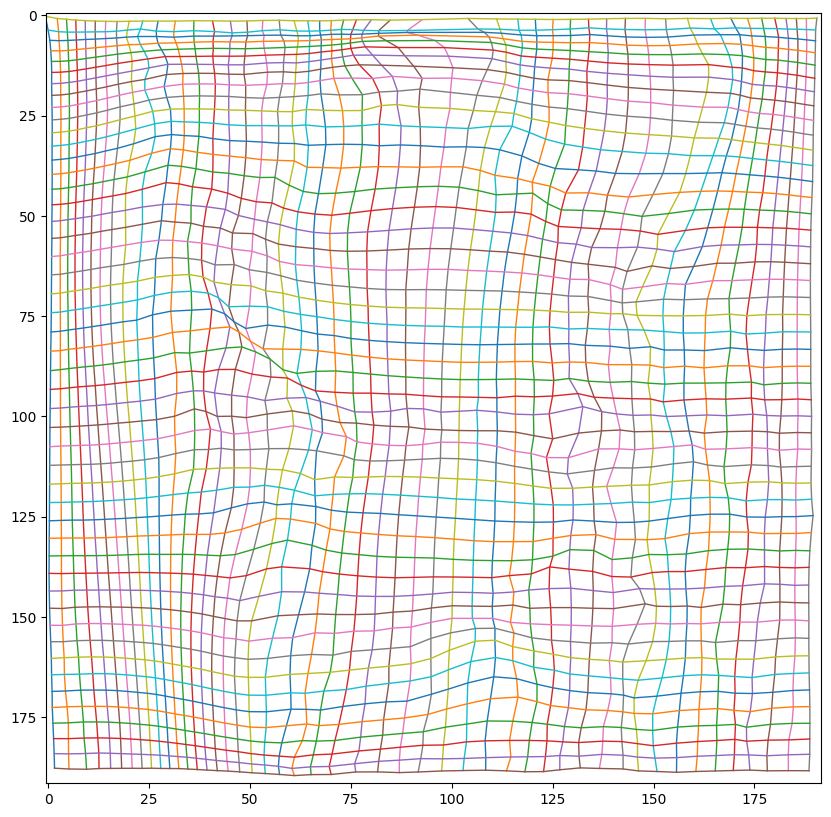

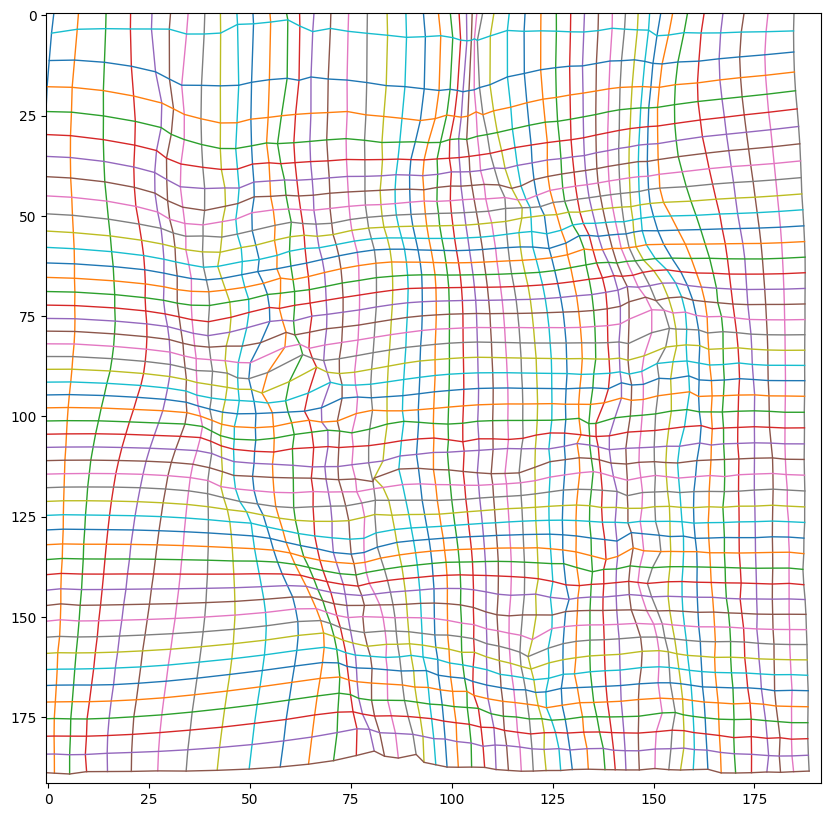

In [17]:
import icon_registration.visualize as visualize
N = (N + 1)% 2
#N = 1
plt.rcParams["figure.figsize"] = 10, 10
visualize.show_as_grid(net.phi_AB_vectorfield[N, [1, 2], 20])
plt.show()
visualize.show_as_grid(net.phi_BA_vectorfield[N, [1, 2], 20])


In [18]:
net.phi_AB.__closure__[0].cell_contents

<function __main__.TwoStepDownsampleRegistration.forward.<locals>.<lambda>(input_)>

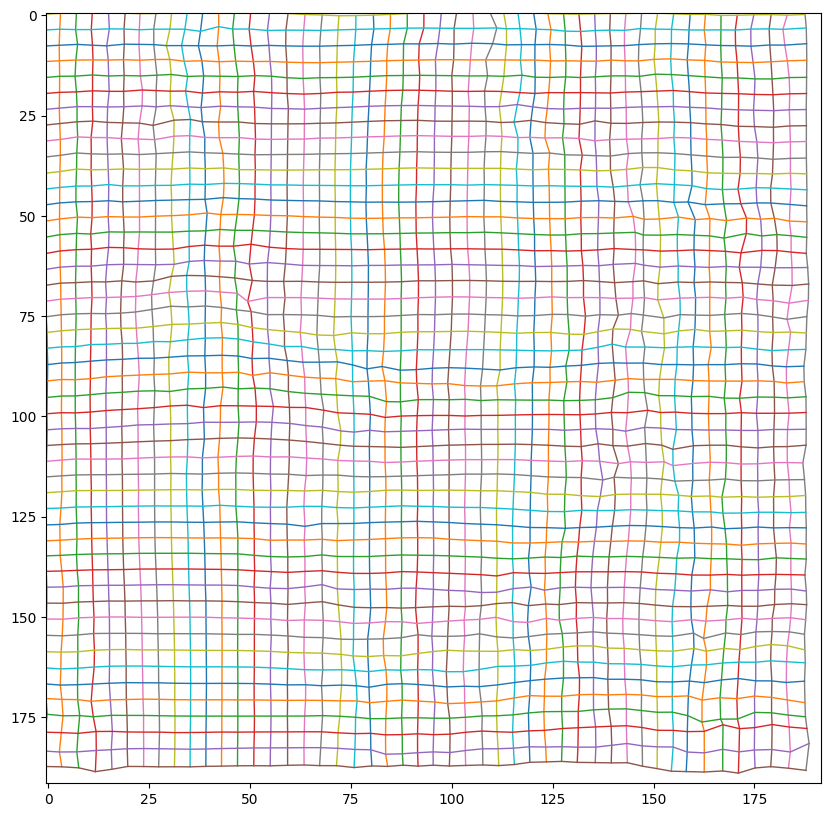

In [19]:
N = (N + 1) % 2
visualize.show_as_grid(net.phi_BA(net.phi_AB(net.identity_map))[N, [1, 2], 20])

In [20]:
import visualize
mp = pretrained_lowres_net.phi_AB(hires_Net.identityMap[:, :, ::2, ::2, ::2])
visualize.show_as_grid(mp[N, [1, 2], 20])

ModuleNotFoundError: No module named 'visualize'

In [ ]:
import visualize
mp = hires_Net.phi_BA(hires_Net.regis_net.net.identityMap)
visualize.show_as_grid(mp[N, [1, 2], 20])

In [ ]:
mkdir supll_regis_figures


In [ ]:
import importlib
importlib.reload(visualize)
import matplotlib.colors as colors

for N in range(2):

    plt.rcParams["figure.figsize"] = (5, 5)
    def imshow(x):
        plt.xticks([])
        plt.yticks([])
        plt.imshow(np.abs(x.cpu().detach()), vmin=0, vmax=1, cmap="gray")
    offset = 0
    slice_ = 20
    
    for axis in ["Coronal", "Sagittal", "Axial"]:
        m_image = moving_image[N, 0].cpu().detach()
        f_image = fixed_image[N, 0].cpu().detach()
        m_warped_image_A = net.warped_image_A[N, 0].cpu().detach() 
        phi_BA = net.phi_BA_vectorfield[N]
        
        dV = flips2(net.phi_AB_vectorfield)[N, 0]
        
        if axis == "Sagittal":
            m_image_slice = m_image[slice_]
            f_image_slice = f_image[slice_]
            warped_image_A_slice = m_warped_image_A[slice_]
            phi_BA_slice = phi_BA[[1, 2], 20].clone()
            dV_slice = dV[slice_]
        if axis == "Coronal":
            m_image_slice = m_image[:, slice_].transpose(0, 1)
            f_image_slice = f_image[:, slice_].transpose(0, 1)
            warped_image_A_slice = m_warped_image_A[:, slice_].transpose(0, 1)
            phi_BA_slice = phi_BA[[2, 0], :, slice_].clone()
            phi_BA_slice[1] *= (79 / 181)
            dV_slice = dV[:, slice_].transpose(0, 1)
        if axis == "Axial":
            slice_ *= 2
            m_image_slice = m_image[:, :, slice_].transpose(0, 1)
            f_image_slice = f_image[:, :, slice_].transpose(0, 1)
            warped_image_A_slice = m_warped_image_A[:, :, slice_].transpose(0, 1)
            phi_BA_slice = phi_BA[[1, 0], :, :, slice_].clone()
            phi_BA_slice[1] *= (79 / 181)
            dV_slice = dV[:, :, slice_].transpose(0, 1)
            slice_ /= 2
            
            
        
        header = f"supll_regis_figures/{axis}Pair{N + offset}"
        imshow(m_image_slice)
        plt.savefig(header + "ImageA.png", bbox_inches="tight")
        plt.clf()
        imshow(f_image_slice)
        plt.savefig(header + "ImageB.png", bbox_inches="tight")
        plt.clf()
        imshow(warped_image_A_slice)
        plt.savefig(header + "WarpedImageA.png", bbox_inches="tight")
        plt.clf()
        imshow(warped_image_A_slice)
        visualize.show_as_grid(phi_BA_slice)
        plt.savefig(header + "WarpedImageAGrid.png", bbox_inches="tight")
        plt.clf()
        
        plt.xticks([])
        plt.yticks([])
        
        plt.imshow(dV_slice, norm=colors.LogNorm(vmin=torch.min(dV[dV > 0]), vmax=torch.max(dV)))
        plt.title("min dV is $\\bf{" + f"{np.min(dV_slice.numpy()):.3}" + "}$ in this slice", 
                 fontdict={'fontsize':13})
        plt.colorbar(label="dV")#, fraction=0.046, pad=0.04)
        #lt.show()
        #plt.imshow(dV[1, 0, 40] < 0)


        plt.savefig(header + "dV.png", bbox_inches="tight")
        plt.clf()
    """
    imshow(net.warped_image_B[N, 0, slice_ ].cpu().detach())
    plt.savefig(f"supll_regis_figures/Pair{N + offset}WarpedImageB.png")
    plt.clf()
    imshow(net.warped_image_B[N, 0, slice_].cpu().detach())
    visualize.show_as_grid(net.phi_AB_vectorfield[N, [1, 2], 20])
    plt.savefig(f"supll_regis_figures/Pair{N + offset}WarpedImageBGrid.png")
    plt.clf()
    """

    
    plt.show()

In [ ]:
import importlib
importlib.reload(visualize)

In [ ]:
plt.imshow(torch.min(dV[1, 0], axis=0).values)
plt.colorbar()

In [ ]:
torch.sum(dV[1] < 0)

In [ ]:
dV

In [ ]:
116 / (80 * 192 * 192), 1 / 25000

In [ ]:
import matplotlib.colors as colors

plt.xticks([])
plt.yticks([])
query = dV[0, 0, 43]
plt.imshow(query, norm=colors.LogNorm(vmin=torch.min(dV[dV > 0]), vmax=torch.max(dV)))
plt.title("dV attains a minimum of $\\bf{" + f"{np.min(query.numpy()):.3}" + "}$ in this slice", 
         fontdict={'fontsize':13})
plt.colorbar(label="dV")#, fraction=0.046, pad=0.04)
#lt.show()
#plt.imshow(dV[1, 0, 40] < 0)


plt.savefig("dVslice0.pdf", bbox_inches="tight")


In [ ]:
2 * np.sum(folds_list) / (np.product(list(dV.shape)) * len(r_ds))

In [ ]:
print("dV attains a minimum of $\\bf{" + f"{np.min(query.numpy()):.3}" + "}$ in this slice")
from matplotlib import rc
rc('text', usetex=False)
np.min(query.numpy())

In [ ]:
adv = np.array(dV)
filteredDV = adv[adv < 0.05]
plt.hist(filteredDV, bins=100)
plt.show()

In [ ]:
plt.hist(np.concatenate(filteredDV_list), bins=100)
plt.title("Distribution of negative dV voxels in test set")
plt.xlabel("dV (in voxels³)")
plt.ylabel("Count")
plt.savefig("DistributionNegativeJacobian.pdf")

In [ ]:
np.mean(np.concatenate(filteredDV_list))

In [ ]:
np.median(np.concatenate(filteredDV_list))

In [ ]:
np.percentile(np.concatenate(filteredDV_list), 1)

In [ ]:
%time net.regis_net(moving_image, fixed_image)

In [ ]:

with torch.no_grad():
    x = batched_ds[0]
    x = list(zip(*x))
    x = [torch.cat(r, 0).cuda().float() for r in x]
    fixed_image, fixed_cartilage = x[0], x[2]
    moving_image, moving_cartilage = x[1], x[3]
    

In [ ]:
%%time
with torch.no_grad():
    phi = net.regis_net(moving_image, fixed_image)
    phi_AB_vectorfield = phi(net.identityMap).cpu()

In [ ]:
%%time 
net(moving_image, fixed_image)

In [ ]:
plt.hist(torch.cat(dices).cpu().detach().numpy(), bins=30)

In [ ]:
pixel_displacement = ((net.phi_AB_vectorfield.cpu() - net.identityMap.cpu()) 
    * torch.tensor(net.phi_AB_vectorfield.shape)[None, 2:, None, None, None])
plt.imshow(pixel_displacement[0, 2, 40], cmap="rainbow")
plt.colorbar()

In [ ]:
torch.max(torch.abs(pixel_displacement))

In [ ]:
error = (net.phi_AB(net.phi_BA_vectorfield) - net.identityMap).cpu()* torch.tensor(net.phi_AB_vectorfield.shape)[None, 2:, None, None, None]

In [ ]:
plt.imshow((error)[0, 0, 40])
plt.colorbar()

In [ ]:
torch.sqrt(torch.mean(error**2))

In [ ]:
plt.rcParams["figure.figsize"]

In [ ]:
plt.hist(folds_list, bins=40)
plt.xlabel("number of folded pixels")
plt.ylabel("number of image pairs")

In [ ]:


import pickle
with open("../results/grad_hires-1/loss_curve", "rb") as f:
    ncurve2 = pickle.load(f)
ncurve2 = [[a, b, c, torch.mean(d).item(), e] for (a, b, c, d, e) in ncurve2]
ncurve2 = np.array(ncurve2)
plt.plot(ncurve2)


import pickle
with open("../../masked_similarity_InvCon/results/hires_smart_6/loss_curve", "rb") as f:
    curve = pickle.load(f)
curve = [[a, b, c, torch.mean(d).item(), e] for (a, b, c, d, e) in curve]
curve = np.array(curve)
plt.plot(curve)


import pickle
with open("../../masked_similarity_InvCon/results/fourth_net_frozen/loss_curve", "rb") as f:
    curve4 = pickle.load(f)
curve4 = [[a, b, c, torch.mean(d).item(), e] for (a, b, c, d, e) in curve4]
curve4 = np.array(curve4)
plt.plot(curve4)

In [ ]:


plt.plot(ncurve2[:, 2])

plt.plot(curve[:, 2])

plt.plot(curve4[:, 2])



In [ ]:


plt.plot(ncurve2[:, 1])


plt.plot(curve[:, 1])

plt.plot(curve4[:, 1])



In [ ]:


plt.plot(ncurve2[:, 3])


plt.plot(curve[:, 3])